In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve

In [44]:
# load dataset
cols = ["max", "min", "wind", "humidi", "pressure", "rain"]
data = pd.read_csv('./weather.csv', usecols=cols)

# filter NaN
data = data.dropna()

# convert categorical data to numeric
data = pd.get_dummies(data, drop_first=True)
print(data.head(200))

     max  min  wind  rain  humidi  pressure
0     29   22     6  18.5      89      1010
1     34   24     5   0.0      59      1010
2     29   23     4   0.2      81      1008
3     32   23     7   1.8      76      1012
4     33   24     4   0.0      69      1010
..   ...  ...   ...   ...     ...       ...
195   33   23     7   0.0      62      1015
196   32   22     3   1.4      76      1009
197   32   24     7   2.6      75      1010
198   33   23     6   0.1      73      1011
199   33   23     5   0.4      71      1012

[200 rows x 6 columns]


               max       min      wind      rain    humidi  pressure
max       1.000000  0.457239  0.120599 -0.391191 -0.763096  0.223329
min       0.457239  1.000000  0.257205  0.106058 -0.195144 -0.311480
wind      0.120599  0.257205  1.000000  0.052858 -0.232067 -0.139314
rain     -0.391191  0.106058  0.052858  1.000000  0.517963 -0.387119
humidi   -0.763096 -0.195144 -0.232067  0.517963  1.000000 -0.519677
pressure  0.223329 -0.311480 -0.139314 -0.387119 -0.519677  1.000000


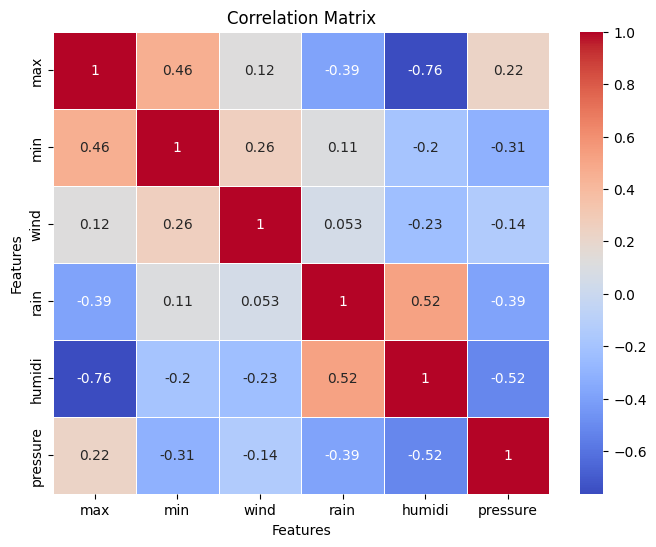

In [45]:
df = pd.DataFrame(data)

corr_mat = df.corr()

print(corr_mat)

# Set the figure size
plt.figure(figsize=(8, 6))

# Create the heatmap
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt='.2g', linewidths=.5)

# Add title and labels
plt.title('Correlation Matrix')
plt.xlabel('Features')
plt.ylabel('Features')

# Display the plot
plt.show()

In [46]:
### Pre-processing data
X = data[["max", "min", "wind", "humidi", "pressure"]]
y = data["rain"]
y = (y > 0).astype(int)

# Using pipeline to configure the model 
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        max_iter=1000,
        random_state=42,
        class_weight="balanced"
    ))
])

# Splitting the sample
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [47]:
pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not wo

In [48]:
y_prob = pipeline.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Find the threshold for predicting rain using the F1 formula to reduce FN (False negative)
f1 = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
best_threshold = thresholds[np.argmax(f1)]

print("Chosen threshold:", best_threshold)

Chosen threshold: 0.13448115923666745


In [49]:
y_prob = pipeline.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= best_threshold).astype(int)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', conf_matrix)

class_report = classification_report(y_test, y_pred)
print('Classification Report:\n', class_report)

Confusion Matrix:
 [[134  78]
 [ 23 675]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.63      0.73       212
           1       0.90      0.97      0.93       698

    accuracy                           0.89       910
   macro avg       0.87      0.80      0.83       910
weighted avg       0.89      0.89      0.88       910



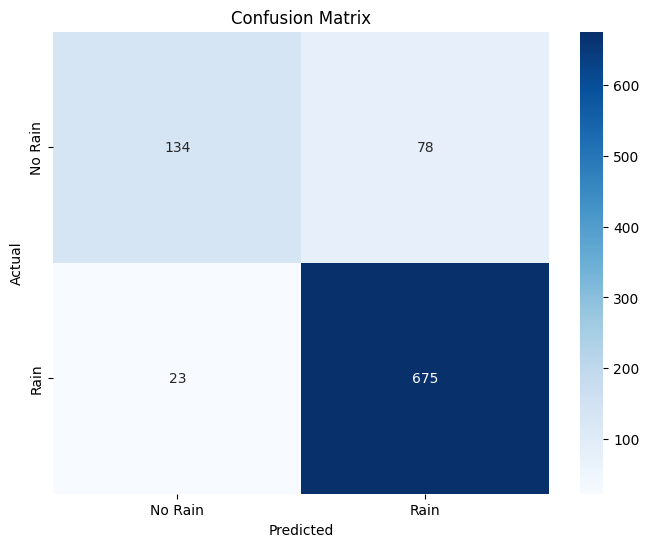

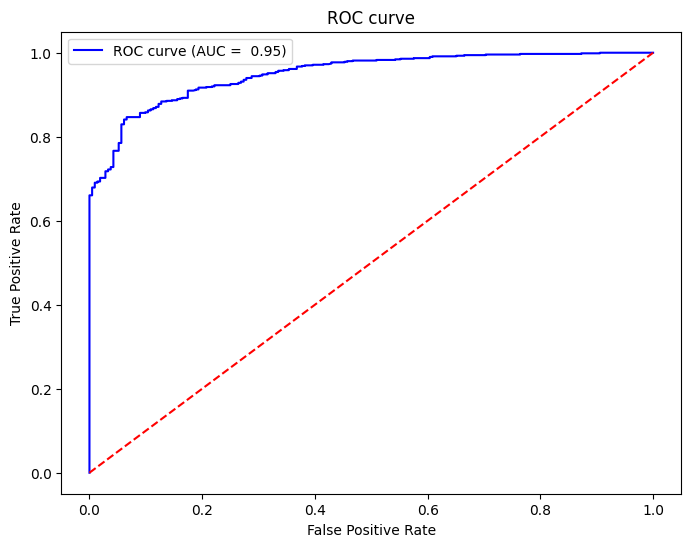

In [50]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

y_prob = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f"ROC curve (AUC = {roc_auc: .2f})")
plt.plot([0,1], [0,1], color='red', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend()
plt.show()

In [54]:
# K-Fold: 5-Fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

f1_scores = cross_val_score(pipeline, X_test, y_test, cv=5, scoring="f1")

print("F1 per fold:", f1_scores)
print("Average F1:", np.mean(f1_scores))

F1 per fold: [0.89056604 0.92134831 0.90636704 0.90636704 0.91954023]
Average F1: 0.9088377329249303


In [52]:
# save the model
joblib.dump(pipeline, 'rain_prediction.pkl')
joblib.dump(X_test, "X_test.pkl")
print('Model saved successfully')

Model saved successfully


In [53]:
loaded_pipeline = joblib.load("rain_prediction.pkl")
print("Model loaded successfully")

# Load test sample saved previously
X_test = joblib.load("X_test.pkl")

# Predict class probabilities
proba = loaded_pipeline.predict_proba(X_test)

# Predicted class
y_pred = loaded_pipeline.predict(X_test)

# Confidence of predicted class
confidence = proba.max(axis=1)

for i in range(10):
    print(f"Prediction: {"Yes" if y_pred[i] == 1 else "No"} - Confidence: {confidence[i]:.2f}")

Model loaded successfully
Prediction: Yes - Confidence: 0.87
Prediction: No - Confidence: 0.98
Prediction: No - Confidence: 0.81
Prediction: Yes - Confidence: 0.98
Prediction: Yes - Confidence: 0.98
Prediction: No - Confidence: 0.99
Prediction: No - Confidence: 0.90
Prediction: Yes - Confidence: 0.57
Prediction: No - Confidence: 0.57
Prediction: Yes - Confidence: 0.85
